## Load data

In [129]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path

pd.set_option('display.max_rows', 30)

In [130]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['rep', 'fps', 'highquality', 'index'])
    return df


def make_df(path: str):
    with open(path, "r") as f:

        p = Path(path)

        x = p.stem.split("_")
        data = {}
        data['fps'] = int(x[1])
        data['highquality'] = bool(x[3])

        rep_no = [x[-1] for x in path.split('/') if 'rep' in x][0]
        data['rep'] = int(rep_no)
        content = json.load(f)
        data['records'] = content['_checkpoint']['records']

        df = pd.DataFrame(data)
        return process_df(df)

In [131]:
dfs = []
path = "data/ronin/*/*/*.json"
for file_path in glob.glob(path):
    # print(file_path)
    dfs.append(make_df(file_path))

In [132]:
df_combined = pd.concat(dfs).sort_index()
df_combined = df_combined.drop('16', level=1, axis=0)
# .drop('lion', level=0, axis=0, inplace=True)
df_combined.info()

KeyError: "['16'] not found in axis"

## FPS factor, in high fidelity

In [ ]:

df = df_combined.xs("True", level='highquality')
df = df.reset_index()
df.groupby('fps')["score_composed"].mean().sort_index(ascending=False)

fps
20    86.145020
18    86.585513
17    82.513808
15    80.318854
14    75.847630
12    59.264614
10    48.476912
Name: score_composed, dtype: float64

In [ ]:
def plot(column: str, ax=None, col="b"):
    axes = df.groupby('fps')[column].mean().sort_index(
        ascending=False).plot(linestyle='dashed', marker='s', color=col,)

    return axes

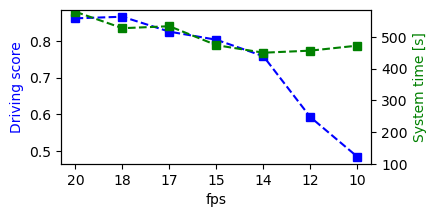

In [ ]:
fig, axes = plt.subplots(squeeze=True)
fig.set_size_inches(4, 2)
axes = plot("driving_score", axes)
axes.set_ylabel(f"Driving score", color='b')


axes = plot("duration_system", axes.twinx(), 'g')
axes.set_ylabel(f"System time [s]", color='g')
axes.set_ylim(100)

fig.savefig('plot.pdf', bbox_inches='tight')
# fig